In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'pogusthewhisper'
os.environ['KAGGLE_KEY'] = '755720e5147a6550b4d67a3b66981cb4'

In [2]:
!pip install -q split-folders

In [3]:
import shutil
import os

src = '/kaggle/input/wound-classification/Wound_dataset copy'
dest = '/kaggle/working/pre_dataset'

exclude_folders = ['Diabetic Wounds', 'Surgical Wounds','Venous Wounds', 'Pressure Wounds', 'Laseration']

shutil.copytree(src, dest, dirs_exist_ok=True)

for root, dirs, files in os.walk(dest, topdown=False):
    for dir_name in dirs:
        if dir_name in exclude_folders:
            folder_to_remove = os.path.join(root, dir_name)
            shutil.rmtree(folder_to_remove)
            print(f"Removed: {folder_to_remove}")

Removed: /kaggle/working/pre_dataset/Surgical Wounds
Removed: /kaggle/working/pre_dataset/Laseration
Removed: /kaggle/working/pre_dataset/Venous Wounds
Removed: /kaggle/working/pre_dataset/Pressure Wounds
Removed: /kaggle/working/pre_dataset/Diabetic Wounds


In [4]:
def count_files_in_subfolders(directory):
    total_files = 0
    folder_file_counts = {}
    
    for root, dirs, files in os.walk(directory):
        if root == directory:
            continue
        folder_name = os.path.basename(root)
        file_count = len(files)
        total_files += file_count
        folder_file_counts[folder_name] = file_count

    print(f"Total files: {total_files}\n")
    accumulated_ratio = 0
    for folder_name, file_count in folder_file_counts.items():
        if file_count > 0:
            ratio = file_count / total_files if total_files > 0 else 0
            print(f"Folder: {folder_name} - File count: {file_count} - Ratio: {ratio:.2%}")
            accumulated_ratio += ratio
    print(f"Sum of ratios (as float): {accumulated_ratio:.2f}")

In [5]:
count_files_in_subfolders('/kaggle/working/pre_dataset')

Total files: 840

Folder: Normal - File count: 200 - Ratio: 23.81%
Folder: Cut - File count: 100 - Ratio: 11.90%
Folder: Abrasions - File count: 164 - Ratio: 19.52%
Folder: Bruises - File count: 242 - Ratio: 28.81%
Folder: Burns - File count: 134 - Ratio: 15.95%
Sum of ratios (as float): 1.00


In [6]:
import splitfolders
splitfolders.ratio("/kaggle/working/pre_dataset", 
                    output="/kaggle/working/dataset",
                    seed=69, 
                    ratio=(.7, .15, .15), 
                    move=False)
!rm -r '/kaggle/working/pre_dataset'

Copying files: 840 files [00:00, 6620.73 files/s]


In [7]:
count_files_in_subfolders('/kaggle/working/dataset/train')

Total files: 586

Folder: Normal - File count: 140 - Ratio: 23.89%
Folder: Cut - File count: 70 - Ratio: 11.95%
Folder: Abrasions - File count: 114 - Ratio: 19.45%
Folder: Bruises - File count: 169 - Ratio: 28.84%
Folder: Burns - File count: 93 - Ratio: 15.87%
Sum of ratios (as float): 1.00


In [8]:
count_files_in_subfolders('/kaggle/working/dataset/test')

Total files: 129

Folder: Normal - File count: 30 - Ratio: 23.26%
Folder: Cut - File count: 15 - Ratio: 11.63%
Folder: Abrasions - File count: 26 - Ratio: 20.16%
Folder: Bruises - File count: 37 - Ratio: 28.68%
Folder: Burns - File count: 21 - Ratio: 16.28%
Sum of ratios (as float): 1.00


In [9]:
count_files_in_subfolders('/kaggle/working/dataset/val')

Total files: 125

Folder: Normal - File count: 30 - Ratio: 24.00%
Folder: Cut - File count: 15 - Ratio: 12.00%
Folder: Abrasions - File count: 24 - Ratio: 19.20%
Folder: Bruises - File count: 36 - Ratio: 28.80%
Folder: Burns - File count: 20 - Ratio: 16.00%
Sum of ratios (as float): 1.00


In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [11]:
train_dir = '/kaggle/working/dataset/train'
test_dir = '/kaggle/working/dataset/test'
val_dir = '/kaggle/working/dataset/val'

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [12]:
class WoundClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout=0.4):
        super().__init__()

        base = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
        n_features = base.classifier[1].in_features
        base.classifier = nn.Identity()
        self.backbone = base

        self.shared_head = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout)
        )

        self.class_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

        self.layer_groups = [
            self.backbone.features[0:2],
            self.backbone.features[2:4],
            self.backbone.features[4:6],
            self.backbone.features[6:]
        ]

    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_head(x)
        cls_out = self.class_head(x)
        return cls_out

    def freeze_all(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_all(self):
        for param in self.backbone.parameters():
            param.requires_grad = True

    def unfreeze_group(self, group_idx):
        for param in self.layer_groups[group_idx].parameters():
            param.requires_grad = True

    def freeze_group(self, group_idx):
        for param in self.layer_groups[group_idx].parameters():
            param.requires_grad = False

In [13]:
class FocalLossWithSmoothing(nn.Module):
    def __init__(self, gamma=2.0, smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, logits, targets):
        num_classes = logits.size(1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)

        log_probs = F.log_softmax(logits, dim=1)
        probs = torch.exp(log_probs)
        focal = (1 - probs.gather(1, targets.unsqueeze(1)).squeeze(1)) ** self.gamma
        loss = -torch.sum(true_dist * log_probs, dim=1)
        return (focal * loss).mean()

class ClassificationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cls_loss = FocalLossWithSmoothing()

    def forward(self, cls_pred, cls_target):
        loss_cls = self.cls_loss(cls_pred, cls_target)
        return loss_cls, loss_cls.item()

In [14]:
class EarlyStopping:
    def __init__(self, patience=6, delta=0.0, save_path='best_model.pt'):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [15]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np

def create_sampler(subset):
    labels = [subset.dataset.targets[i] for i in subset.indices]
    class_counts = Counter(labels)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    weights = [class_weights[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

def get_kfold_dataloaders(dataset, k=5, batch_size=32, val_dir='/kaggle/working/dataset/val'):
    y = dataset.targets
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    folds = []

    val_dataset = datasets.ImageFolder(val_dir, transform=val_tf)

    for train_idx, _ in skf.split(np.arange(len(dataset)), y):
        train_ds = Subset(dataset, train_idx)
        train_ds.dataset.transform = train_tf

        val_ds = val_dataset  # Use fixed validation set

        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=create_sampler(train_ds))
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        folds.append({'train': train_loader, 'val': val_loader})

    return folds

In [16]:
def train_top_down(model_class, dataset, num_classes=5, stages=4, epochs_per_stage=10,
                   batch_size=16, base_lr=5e-4, weight_decay=5e-5,
                   patience=5, device='cuda' if torch.cuda.is_available() else 'cpu'):

    folds = get_kfold_dataloaders(dataset, k=5, batch_size=batch_size, val_dir=val_dir)
    results = []

    for fold_idx, loaders in enumerate(folds):
        print(f"\n🔁 Starting Fold {fold_idx + 1}/5")

        model = model_class(num_classes=num_classes).to(device)
        model.freeze_all()
        model.shared_head.requires_grad_(True)
        model.class_head.requires_grad_(True)

        train_loader = loaders['train']
        val_loader = loaders['val']
        loss_fn = ClassificationLoss()

        for stage in range(stages):
            print(f"\nStage {stage + 1}/{stages}: Unfreezing group {stage}")
            if stage > 0:
                model.unfreeze_group(stage - 1)

            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                          lr=base_lr * (0.5 ** stage), weight_decay=weight_decay)
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_per_stage)
            scaler = GradScaler()
            early_stopper = EarlyStopping(patience=patience,
                                          save_path=f'topdown_model_fold{fold_idx}_stage{stage}.pt')

            for epoch in range(epochs_per_stage):
                model.train()
                train_loss = 0.0

                for inputs, targets in train_loader:
                    inputs = inputs.to(device)
                    cls_targets = targets.to(device).long()

                    optimizer.zero_grad()
                    with autocast(device_type=device):
                        cls_out = model(inputs)
                        loss, _ = loss_fn(cls_out, cls_targets)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    train_loss += loss.item() * inputs.size(0)

                train_loss /= len(train_loader.dataset)

                # Validation
                model.eval()
                val_loss = 0.0
                all_preds, all_targets = [], []
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs = inputs.to(device)
                        cls_targets = targets.to(device).long()

                        cls_out = model(inputs)
                        loss, _ = loss_fn(cls_out, cls_targets)
                        val_loss += loss.item() * inputs.size(0)
                        preds = torch.argmax(cls_out, dim=1)
                        all_preds.extend(preds.cpu().numpy())
                        all_targets.extend(cls_targets.cpu().numpy())

                val_loss /= len(val_loader.dataset)
                val_acc = accuracy_score(all_targets, all_preds)
                val_f1 = f1_score(all_targets, all_preds, average='macro')
                scheduler.step()

                print(f"[Fold {fold_idx+1} | Stage {stage+1} | Epoch {epoch+1}/{epochs_per_stage}] "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
                      f"| Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

                early_stopper(val_loss, model)
                if early_stopper.early_stop:
                    print("Early stopping")
                    break

            model.load_state_dict(torch.load(f'topdown_model_fold{fold_idx}_stage{stage}.pt'))

        # Final evaluation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                cls_targets = targets.to(device).long()

                cls_out = model(inputs)
                preds = torch.argmax(cls_out, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(cls_targets.cpu().numpy())

        fold_acc = accuracy_score(all_targets, all_preds)
        fold_f1 = f1_score(all_targets, all_preds, average='macro')
        results.append({'fold': fold_idx + 1, 'accuracy': fold_acc, 'f1': fold_f1})
        print(f"Fold {fold_idx + 1} Accuracy: {fold_acc:.4f}, F1: {fold_f1:.4f}")

    print("\nSummary:")
    for res in results:
        print(f"Fold {res['fold']} - Accuracy: {res['accuracy']:.4f}, F1: {res['f1']:.4f}")
    print(f"\nAvg Accuracy: {np.mean([r['accuracy'] for r in results]):.4f} | "
          f"Avg F1: {np.mean([r['f1'] for r in results]):.4f}")

In [17]:
%%time
dataset = datasets.ImageFolder(train_dir)
train_top_down(WoundClassifier, dataset, num_classes=len(dataset.classes))


🔁 Starting Fold 1/5


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:02<00:00, 230MB/s]



Stage 1/4: Unfreezing group 0
[Fold 1 | Stage 1 | Epoch 1/10] Train Loss: 0.9183 | Val Loss: 0.5784 | Val Acc: 0.7280 | Val F1: 0.7285
[Fold 1 | Stage 1 | Epoch 2/10] Train Loss: 0.6284 | Val Loss: 0.3420 | Val Acc: 0.8080 | Val F1: 0.8100
[Fold 1 | Stage 1 | Epoch 3/10] Train Loss: 0.4679 | Val Loss: 0.3094 | Val Acc: 0.8000 | Val F1: 0.7860
[Fold 1 | Stage 1 | Epoch 4/10] Train Loss: 0.4740 | Val Loss: 0.3433 | Val Acc: 0.8080 | Val F1: 0.8123
[Fold 1 | Stage 1 | Epoch 5/10] Train Loss: 0.5036 | Val Loss: 0.2974 | Val Acc: 0.8400 | Val F1: 0.8306
[Fold 1 | Stage 1 | Epoch 6/10] Train Loss: 0.4236 | Val Loss: 0.2842 | Val Acc: 0.8000 | Val F1: 0.7967
[Fold 1 | Stage 1 | Epoch 7/10] Train Loss: 0.4221 | Val Loss: 0.2910 | Val Acc: 0.7840 | Val F1: 0.7831
[Fold 1 | Stage 1 | Epoch 8/10] Train Loss: 0.4709 | Val Loss: 0.2649 | Val Acc: 0.8000 | Val F1: 0.7969
[Fold 1 | Stage 1 | Epoch 9/10] Train Loss: 0.4038 | Val Loss: 0.2467 | Val Acc: 0.8480 | Val F1: 0.8404
[Fold 1 | Stage 1 | Epoc

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, dataloader, class_names=None, device='cuda'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    print("\nClassification Report:")
    print(classification_report(
        all_targets, all_preds,
        target_names=class_names,
        zero_division=0  # 👈 Avoid warning when a class has no predicted samples
    ))

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, acc in enumerate(per_class_acc):
        name = class_names[idx] if class_names else str(idx)
        print(f"Accuracy for class '{name}': {acc:.2%}")

    return {
        'accuracy': np.mean(all_preds == all_targets),
        'f1_macro': f1_score(all_targets, all_preds, average='macro', zero_division=0),
        'per_class_accuracy': per_class_acc
    }

In [19]:
def evaluate_all_folds(model_class, test_dataset, stages=4, device='cuda'):
    class_names = test_dataset.classes
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    metrics_all = []

    for fold_idx in range(5):
        print(f"\n============================")
        print(f"Evaluating Fold {fold_idx + 1} on Full Test Set")
        print(f"============================")

        model = model_class(num_classes=len(class_names)).to(device)
        model.load_state_dict(torch.load(f'topdown_model_fold{fold_idx}_stage{stages - 1}.pt'))
        model.eval()

        fold_metrics = evaluate_model(model, test_loader, class_names=class_names, device=device)
        metrics_all.append(fold_metrics)

        print(f"Fold {fold_idx + 1} Accuracy: {fold_metrics['accuracy']:.4f}")

    # Summary
    avg_acc = np.mean([m['accuracy'] for m in metrics_all])
    avg_f1 = np.mean([m['f1_macro'] for m in metrics_all])
    print(f"\nAvg Accuracy: {avg_acc:.4f} | Avg F1 Score: {avg_f1:.4f}")

    return metrics_all



Evaluating Fold 1 on Full Test Set

Classification Report:
              precision    recall  f1-score   support

   Abrasions       0.77      0.92      0.84        26
     Bruises       0.97      0.89      0.93        37
       Burns       0.91      0.95      0.93        21
         Cut       0.73      0.73      0.73        15
      Normal       1.00      0.90      0.95        30

    accuracy                           0.89       129
   macro avg       0.88      0.88      0.88       129
weighted avg       0.90      0.89      0.89       129



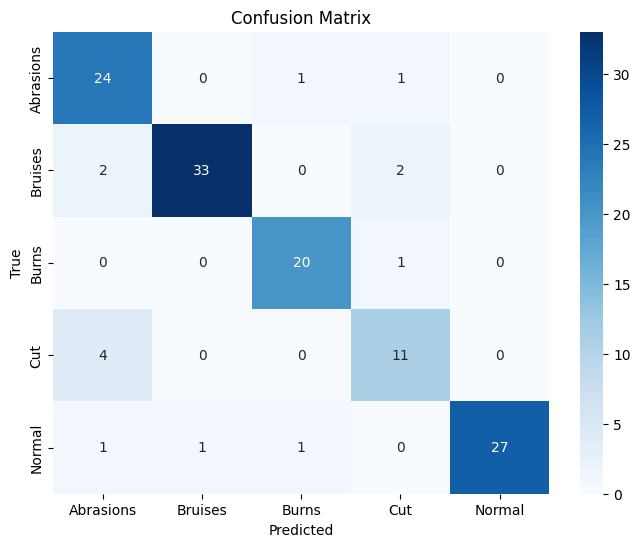

Accuracy for class 'Abrasions': 92.31%
Accuracy for class 'Bruises': 89.19%
Accuracy for class 'Burns': 95.24%
Accuracy for class 'Cut': 73.33%
Accuracy for class 'Normal': 90.00%
Fold 1 Accuracy: 0.8915

Evaluating Fold 2 on Full Test Set

Classification Report:
              precision    recall  f1-score   support

   Abrasions       0.77      0.92      0.84        26
     Bruises       0.97      0.84      0.90        37
       Burns       0.90      0.90      0.90        21
         Cut       0.88      0.93      0.90        15
      Normal       0.93      0.90      0.92        30

    accuracy                           0.89       129
   macro avg       0.89      0.90      0.89       129
weighted avg       0.90      0.89      0.89       129



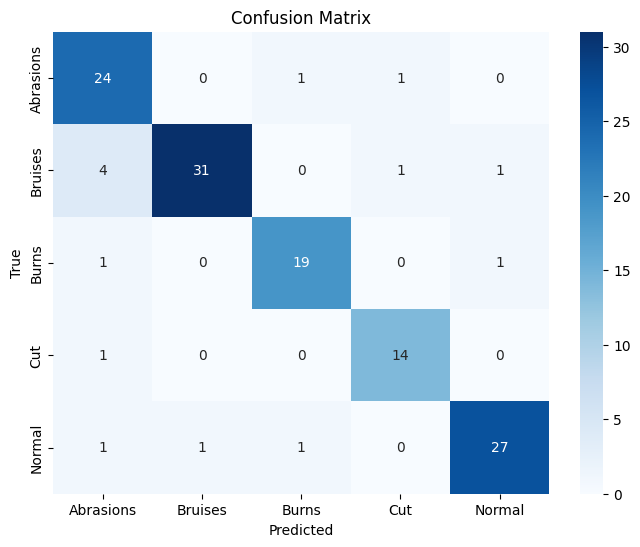

Accuracy for class 'Abrasions': 92.31%
Accuracy for class 'Bruises': 83.78%
Accuracy for class 'Burns': 90.48%
Accuracy for class 'Cut': 93.33%
Accuracy for class 'Normal': 90.00%
Fold 2 Accuracy: 0.8915

Evaluating Fold 3 on Full Test Set

Classification Report:
              precision    recall  f1-score   support

   Abrasions       0.80      0.92      0.86        26
     Bruises       0.95      0.95      0.95        37
       Burns       0.95      0.86      0.90        21
         Cut       0.79      0.73      0.76        15
      Normal       1.00      0.97      0.98        30

    accuracy                           0.91       129
   macro avg       0.90      0.89      0.89       129
weighted avg       0.91      0.91      0.91       129



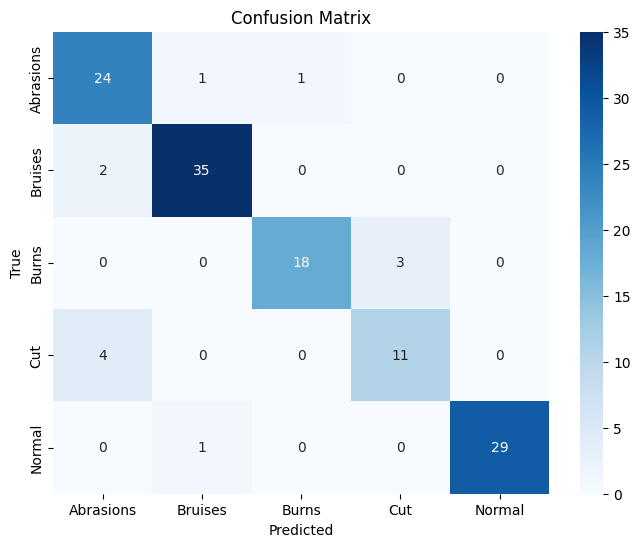

Accuracy for class 'Abrasions': 92.31%
Accuracy for class 'Bruises': 94.59%
Accuracy for class 'Burns': 85.71%
Accuracy for class 'Cut': 73.33%
Accuracy for class 'Normal': 96.67%
Fold 3 Accuracy: 0.9070

Evaluating Fold 4 on Full Test Set

Classification Report:
              precision    recall  f1-score   support

   Abrasions       0.72      1.00      0.84        26
     Bruises       0.97      0.86      0.91        37
       Burns       0.90      0.90      0.90        21
         Cut       1.00      0.67      0.80        15
      Normal       1.00      0.97      0.98        30

    accuracy                           0.90       129
   macro avg       0.92      0.88      0.89       129
weighted avg       0.92      0.90      0.90       129



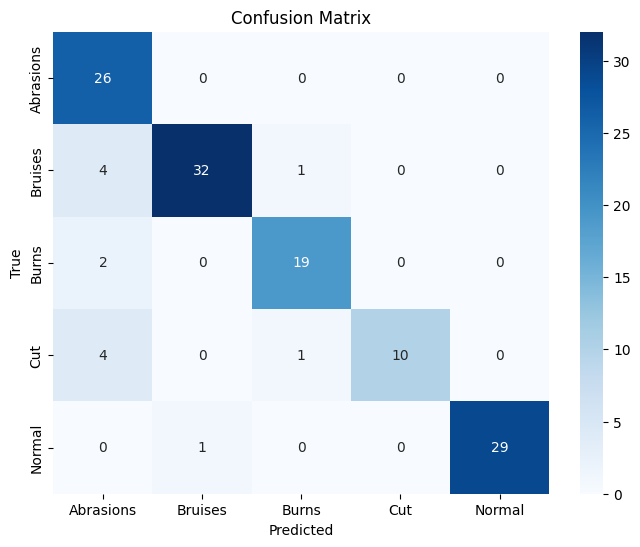

Accuracy for class 'Abrasions': 100.00%
Accuracy for class 'Bruises': 86.49%
Accuracy for class 'Burns': 90.48%
Accuracy for class 'Cut': 66.67%
Accuracy for class 'Normal': 96.67%
Fold 4 Accuracy: 0.8992

Evaluating Fold 5 on Full Test Set

Classification Report:
              precision    recall  f1-score   support

   Abrasions       0.73      0.92      0.81        26
     Bruises       0.97      0.81      0.88        37
       Burns       1.00      0.95      0.98        21
         Cut       0.88      0.93      0.90        15
      Normal       1.00      0.97      0.98        30

    accuracy                           0.91       129
   macro avg       0.91      0.92      0.91       129
weighted avg       0.92      0.91      0.91       129



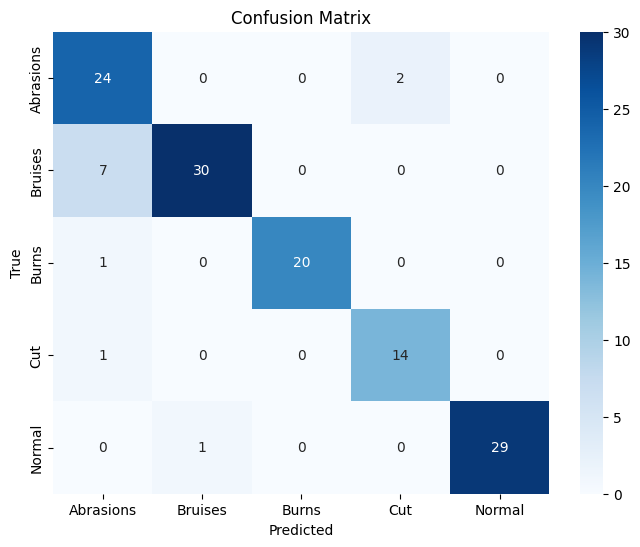

Accuracy for class 'Abrasions': 92.31%
Accuracy for class 'Bruises': 81.08%
Accuracy for class 'Burns': 95.24%
Accuracy for class 'Cut': 93.33%
Accuracy for class 'Normal': 96.67%
Fold 5 Accuracy: 0.9070

Avg Accuracy: 0.8992 | Avg F1 Score: 0.8916


[{'accuracy': 0.8914728682170543,
  'f1_macro': 0.8765234080944253,
  'per_class_accuracy': array([0.92307692, 0.89189189, 0.95238095, 0.73333333, 0.9       ])},
 {'accuracy': 0.8914728682170543,
  'f1_macro': 0.8927795872594458,
  'per_class_accuracy': array([0.92307692, 0.83783784, 0.9047619 , 0.93333333, 0.9       ])},
 {'accuracy': 0.9069767441860465,
  'f1_macro': 0.8889520680403205,
  'per_class_accuracy': array([0.92307692, 0.94594595, 0.85714286, 0.73333333, 0.96666667])},
 {'accuracy': 0.8992248062015504,
  'f1_macro': 0.8881616287849201,
  'per_class_accuracy': array([1.        , 0.86486486, 0.9047619 , 0.66666667, 0.96666667])},
 {'accuracy': 0.9069767441860465,
  'f1_macro': 0.911559734643434,
  'per_class_accuracy': array([0.92307692, 0.81081081, 0.95238095, 0.93333333, 0.96666667])}]

In [20]:
test_dataset = datasets.ImageFolder(test_dir, transform=val_tf)
evaluate_all_folds(WoundClassifier, test_dataset, device='cuda')